In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score, silhouette_samples
from functions import preprocessing, display_silhouettes, display_clusters, display_3D
from IPython.display import display, HTML

# 1/ Dataset upload/overview

In [2]:
dataset = pd.read_csv("data/kaya_dataset.csv")
print(dataset.info())
dataset.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7745 entries, 0 to 7744
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   country              7745 non-null   object 
 1   year                 7745 non-null   int64  
 2   iso_code             7745 non-null   object 
 3   co2                  7745 non-null   float64
 4   energy               7745 non-null   float64
 5   gdp                  7745 non-null   float64
 6   population           7745 non-null   float64
 7   co2_per_unit_energy  7745 non-null   float64
 8   energy_per_gdp       7745 non-null   float64
 9   gdp_per_capita       7745 non-null   float64
dtypes: float64(7), int64(1), object(2)
memory usage: 605.2+ KB
None


,year,co2,energy,gdp,population,co2_per_unit_energy,energy_per_gdp,gdp_per_capita
count,7745.000000,7745.000000,7.745000e+03,7.745000e+03,7.745000e+03,7745.000000,7745.000000,7745.000000
mean,1997.914009,169.430360,7.407782e+11,4.259151e+11,4.002676e+07,0.239455,1.674191,13025.601709
std,15.104324,683.710379,2.786040e+12,1.488989e+12,1.350935e+08,0.200058,1.631089,14718.564983
min,1965.000000,0.022000,9.765923e+07,1.642060e+08,6.408200e+04,0.018000,0.078000,361.188725
25%,1986.000000,3.691000,1.850453e+10,1.803369e+10,3.593782e+06,0.186000,0.767000,2808.878751
50%,1999.000000,20.870000,8.890039e+10,6.434611e+10,9.754398e+06,0.221000,1.245000,7828.856656
75%,2011.000000,84.838000,4.128210e+11,2.542891e+11,2.810118e+07,0.261000,2.053000,18309.742796
max,2022.000000,11711.808000,4.451869e+13,2.696602e+13,1.426437e+09,10.689000,25.253000,163531.400281


In [3]:
datatemp = dataset.iloc[:100]

datatemp.shape 

(100, 10)

# 2/ data and feature selection

### line selection

In [4]:
# countries selection :
countries = dataset.country.unique()
# year selection :
# years = df.year.unique()
years = [2022]  # only 2022
# common columns :
# cols = df.columns.tolist() # select all
df = dataset[dataset["year"].isin(years)]
df = df[df["country"].isin(countries)]
df.shape

(164, 10)

### column selection

In [5]:

# common columns :
# cols = df.columns.tolist() # select all
cols = ['country', 'year', 'iso_code']
# features selection :
features_1 = ['co2', 'energy', 'gdp', 'population']
features_2 = ['co2_per_unit_energy', 'energy_per_gdp', 'gdp_per_capita'] 
features_3 = ['co2_per_unit_energy', 'energy_per_gdp', 'gdp_per_capita', 'population']
features = features_2

# bandwidth parameters
# gamma_values = [0.01, 0.1, 1.0, 10.0,100.0]
gamma_values = [1]
k_values = [3, 4, 5, 6]
# assign_labels="kmeans"
assign_labels = "cluster_qr"


rs = 42 # seed for random functions (center first position)

# 3/ Results

### Sélection des meilleurs paramètres gamma, n_clusters

--------------------
γ = 1
cluster: 3 --> tailles : [  3   6 155] | silh_avg = 0.482


,n_countries,co2,energy,gdp,population,avg_co2_energy,avg_energy_gdp,avg_gdp_capita,silh_mean,%co2,%energy,%gdp,%population
cluster,,,,,,,,,,,,,
0,3,51.722,7.025356e+10,7.325020e+10,1.170723e+07,0.656667,0.910667,6413.375082,0.579732,0.14,0.04,0.06,0.15
1,6,345.694,1.784600e+12,3.999765e+11,6.518181e+07,0.186333,4.410000,20974.446083,0.498868,0.95,1.06,0.31,0.82
2,155,36080.294,1.658415e+14,1.298067e+14,7.833676e+09,0.212406,1.049342,19323.143299,0.479019,98.91,98.89,99.64,99.03


--------------------
γ = 1
cluster: 4 --> tailles : [  3   6  54 101] | silh_avg = 0.383


,n_countries,co2,energy,gdp,population,avg_co2_energy,avg_energy_gdp,avg_gdp_capita,silh_mean,%co2,%energy,%gdp,%population
cluster,,,,,,,,,,,,,
0,3,51.722,7.025356e+10,7.325020e+10,1.170723e+07,0.656667,0.910667,6413.375082,0.516413,0.14,0.04,0.06,0.15
1,6,345.694,1.784600e+12,3.999765e+11,6.518181e+07,0.186333,4.410000,20974.446083,0.450169,0.95,1.06,0.31,0.82
2,54,3958.582,1.478996e+13,1.810627e+13,3.340168e+09,0.250611,0.734167,3467.915673,0.389634,10.85,8.82,13.90,42.22
3,101,32121.712,1.510515e+14,1.117005e+14,4.493507e+09,0.191980,1.217851,27800.195693,0.371075,88.06,90.07,85.74,56.80


--------------------
γ = 1
cluster: 5 --> tailles : [ 3  6 53 42 60] | silh_avg = 0.301


,n_countries,co2,energy,gdp,population,avg_co2_energy,avg_energy_gdp,avg_gdp_capita,silh_mean,%co2,%energy,%gdp,%population
cluster,,,,,,,,,,,,,
0,3,51.722,7.025356e+10,7.325020e+10,1.170723e+07,0.656667,0.910667,6413.375082,0.519361,0.14,0.04,0.06,0.15
1,6,345.694,1.784600e+12,3.999765e+11,6.518181e+07,0.186333,4.410000,20974.446083,0.411955,0.95,1.06,0.31,0.82
2,53,12390.293,7.096879e+13,6.038593e+13,1.566766e+09,0.162075,1.063811,38257.459240,0.358982,33.97,42.32,46.35,19.81
3,42,905.279,3.897771e+12,6.972913e+12,1.744568e+09,0.248381,0.577357,3178.352134,0.407821,2.48,2.32,5.35,22.05
4,60,22784.722,9.097490e+13,6.244787e+13,4.522342e+09,0.231683,1.366950,13899.184700,0.152246,62.46,54.25,47.93,57.17


--------------------
γ = 1
cluster: 6 --> tailles : [ 3  6 37 38 32 48] | silh_avg = 0.254


,n_countries,co2,energy,gdp,population,avg_co2_energy,avg_energy_gdp,avg_gdp_capita,silh_mean,%co2,%energy,%gdp,%population
cluster,,,,,,,,,,,,,
0,3,51.722,7.025356e+10,7.325020e+10,1.170723e+07,0.656667,0.910667,6413.375082,0.507774,0.14,0.04,0.06,0.15
1,6,345.694,1.784600e+12,3.999765e+11,6.518181e+07,0.186333,4.410000,20974.446083,0.375326,0.95,1.06,0.31,0.82
2,37,12081.860,5.979580e+13,4.895394e+13,3.104342e+09,0.191378,1.075243,26219.781492,-0.184815,33.12,35.66,37.58,39.24
3,38,17032.975,6.816050e+13,3.984824e+13,2.329295e+09,0.239079,1.579000,12947.015466,0.206501,46.69,40.65,30.59,29.45
4,32,354.020,1.419468e+12,3.028928e+12,1.085206e+09,0.255937,0.560219,2107.685268,0.506457,0.97,0.85,2.32,13.72
5,48,6611.439,3.646570e+13,3.797561e+13,1.314834e+09,0.178479,0.936146,30531.724579,0.430448,18.12,21.75,29.15,16.62


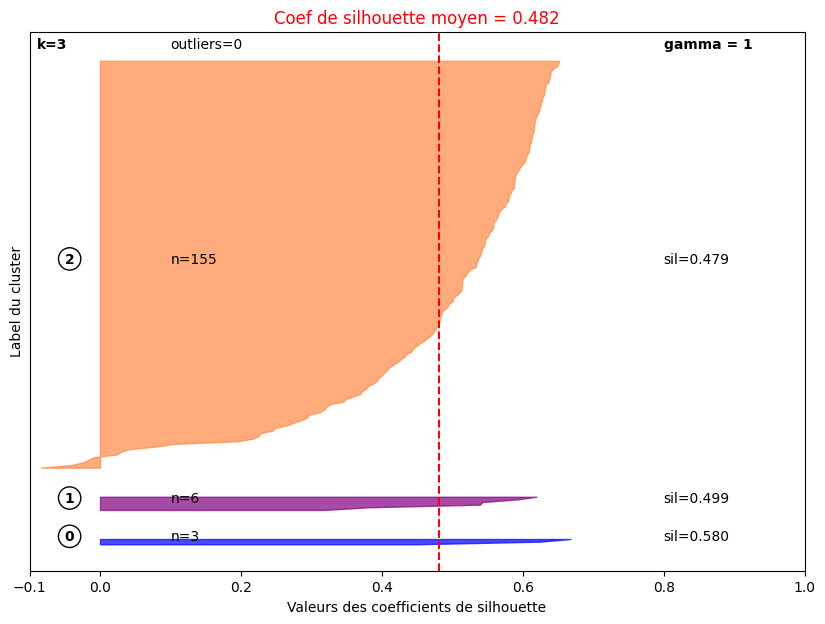

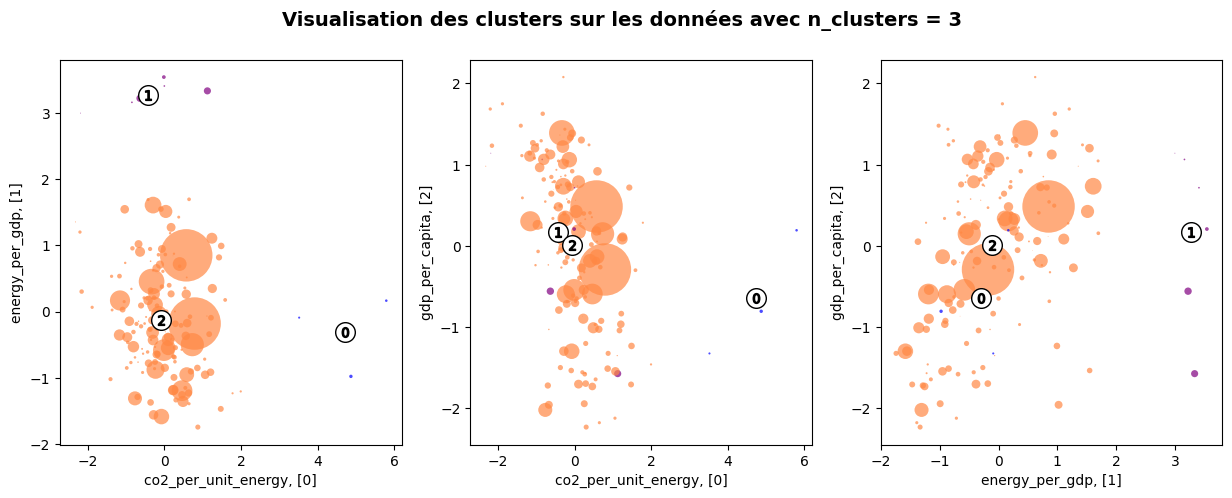

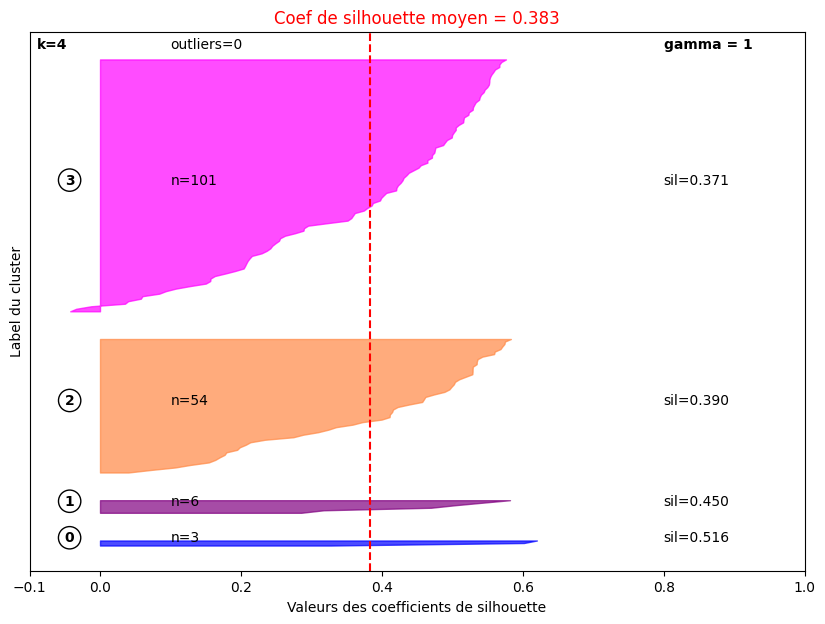

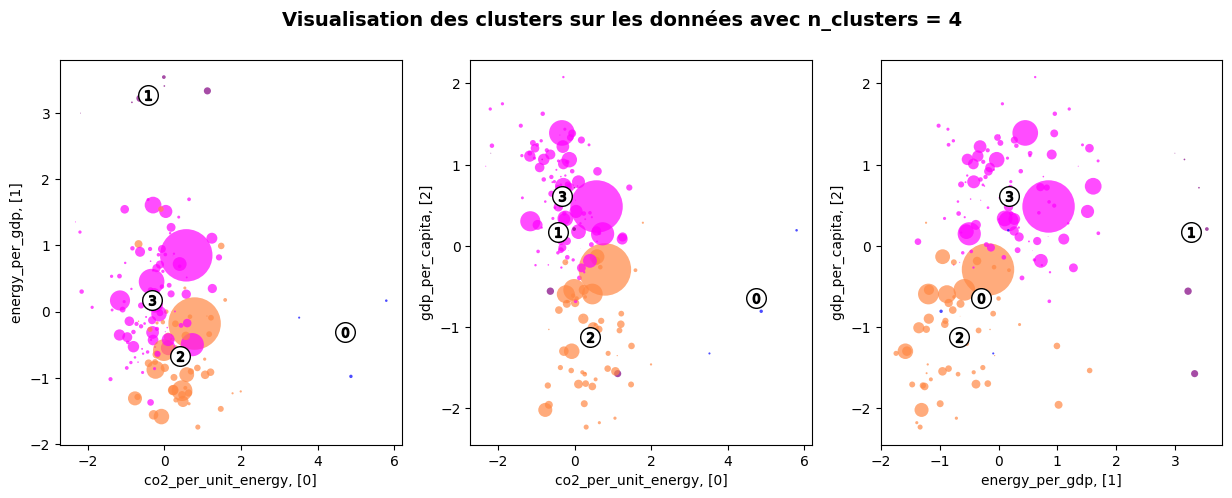

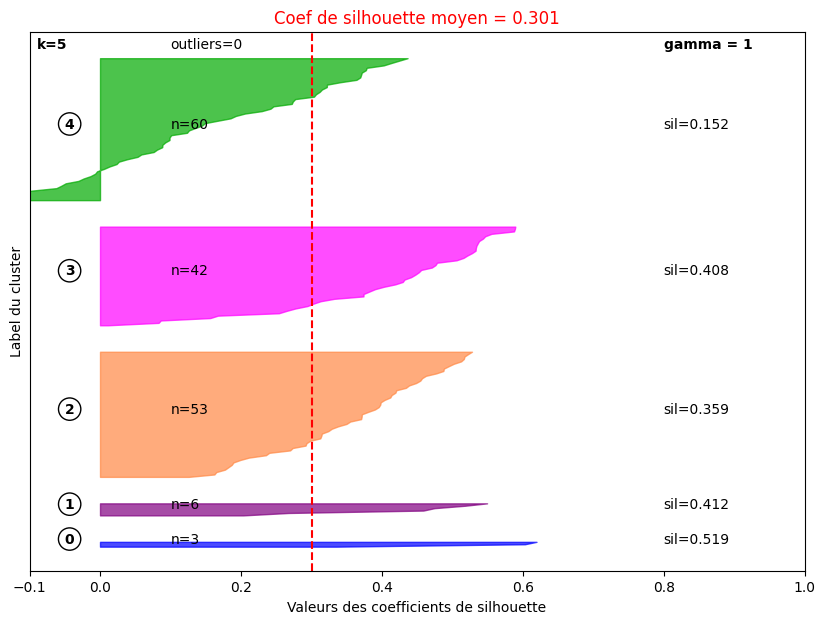

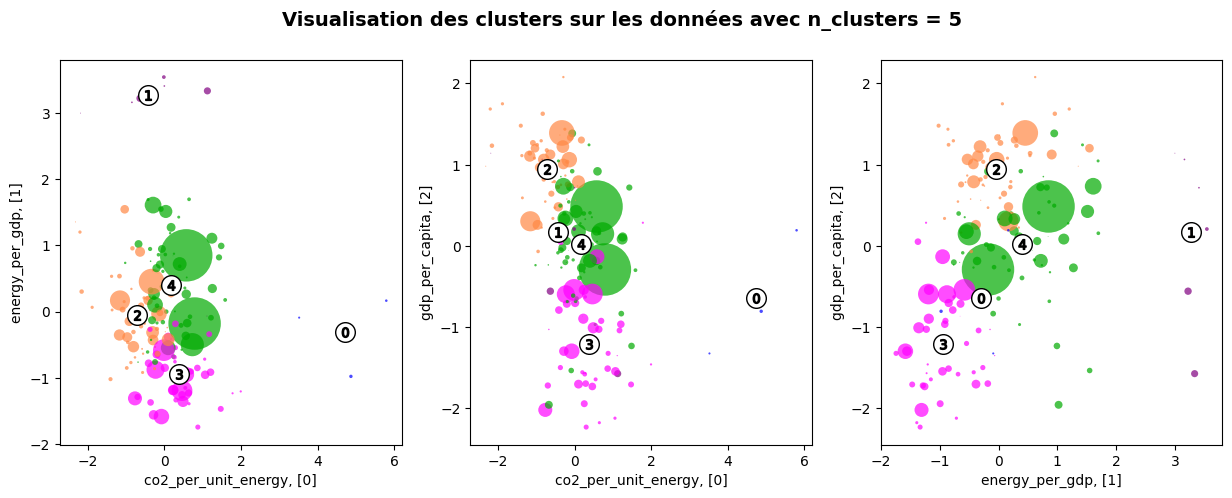

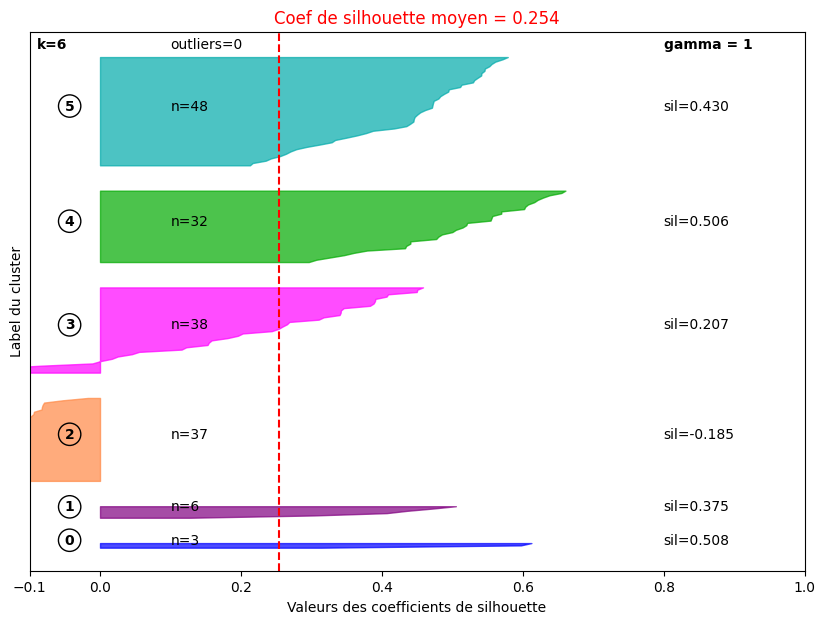

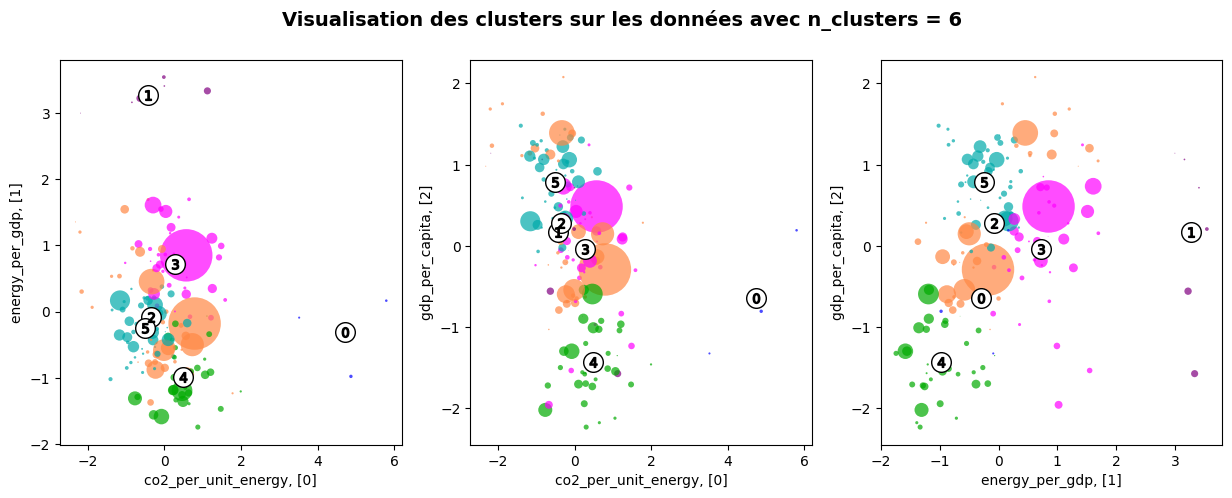

In [6]:
X =  preprocessing(df, years, countries, cols, features)
for n_clusters in k_values:
    for gamma in gamma_values:
        print("-"*20)
        sc = SpectralClustering(
            n_clusters=n_clusters, affinity='rbf', assign_labels=assign_labels, random_state=rs
            )
        cluster_labels = sc.fit_predict(X)

        silhouette_avg = silhouette_score(X, cluster_labels)
        silhouette_sample_values = silhouette_samples(X, cluster_labels)
        df["cluster"] = cluster_labels
        print(f"γ = {gamma}")
        print(f"cluster: {n_clusters} --> tailles : {np.bincount(cluster_labels)} | silh_avg = {silhouette_avg:.3f}")
       
        
       
        cluster_stats = df.groupby("cluster").agg(
            n_countries=("country", "count"),
            co2=("co2", "sum"),
            energy=("energy", "sum"),
            gdp=("gdp", "sum"),
            population=("population", "sum"),
            avg_co2_energy=("co2_per_unit_energy", "mean"),
            avg_energy_gdp=("energy_per_gdp", "mean"),
            avg_gdp_capita=("gdp_per_capita", "mean"),           
        )
        cluster_stats["silh_mean"] = [ np.mean(silhouette_sample_values[cluster_labels == i]) for i in range(n_clusters)]
        
        for feat in ["co2", "energy", "gdp", "population"]:
            cluster_stats[f"%{feat}"] =  (cluster_stats[feat] / cluster_stats[feat].sum() * 100).round(2)
        
                    
         
        

        country_list = [ "|".join(list(df[df["cluster"]==k]["iso_code"])) for k in range(n_clusters) ]
        # cluster_stats["country_list"] = country_list
        
        
            
        # print(cluster_stats)

        display(HTML(cluster_stats.to_html().replace(
            '<table>', '<table style="border-collapse:collapse; text-align:left;">')))

        # GRAPHES :
        fig1 = display_silhouettes(X, n_clusters, cluster_labels, gamma=gamma)
        centers = np.array([X[cluster_labels == i].mean(axis=0) for i in range(n_clusters)])
        fig2 = display_clusters(X, n_clusters, features, centers, cluster_labels, df["population"])

        

### Représentation graphique : sihouette et vues 2D des clusters

γ = 0.1   , k=5 -> tailles : [ 3  6 53 42 60]
γ = 0.1
cluster: 5 --> tailles : [ 3  6 53 42 60]
[]


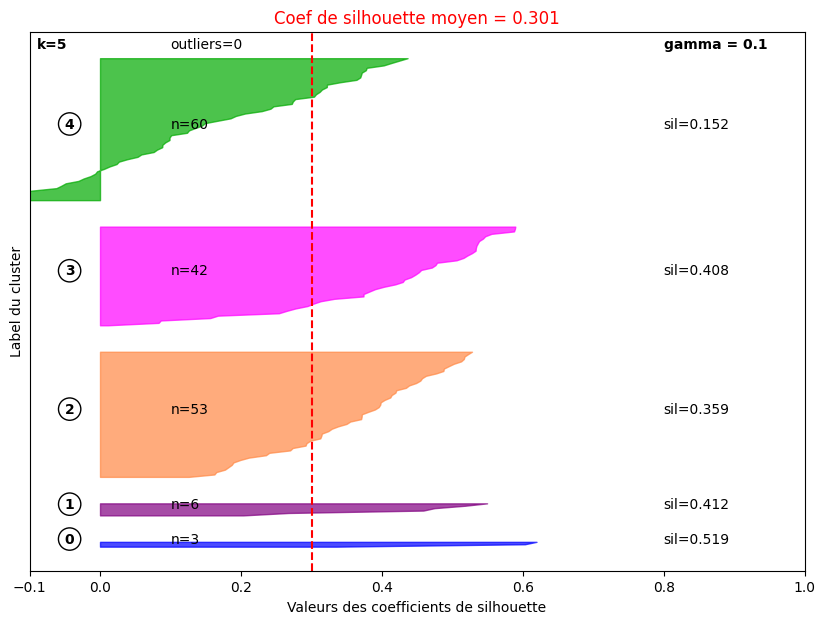

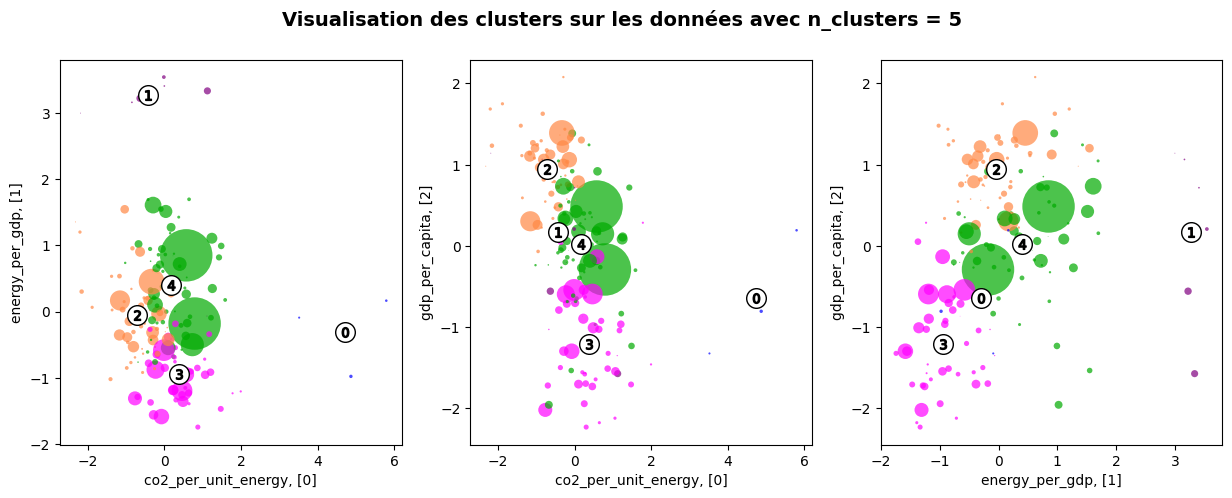

In [7]:
# check rapide :
X =  preprocessing(df, years, countries, cols, features)

gamma = 0.1
n_clusters = 5
assign_labels = "cluster_qr"


sc = SpectralClustering(
    n_clusters=n_clusters, affinity='rbf', assign_labels=assign_labels, random_state=rs
    )
cluster_labels = sc.fit_predict(X)

n_clusters = len(set(cluster_labels) - {-1})

silhouette_avg = silhouette_score(X, cluster_labels)
silhouette_sample_values = silhouette_samples(X, cluster_labels)
print(f"γ = {gamma:<5} , k={n_clusters} -> tailles : {np.bincount(cluster_labels)}")
df["cluster"] = cluster_labels
print(f"γ = {gamma}")
print(f"cluster: {n_clusters} --> tailles : {np.bincount(cluster_labels)}")
print(list(df[df["cluster"]==n_clusters]["country"]))
fig1 = display_silhouettes(X, n_clusters, cluster_labels, gamma=gamma)
centers = np.array([X[cluster_labels == i].mean(axis=0) for i in range(n_clusters)])
fig2 = display_clusters(X, n_clusters, features, centers, cluster_labels, df["population"])


# 4/ Analyse

- le coef gamma n'a aucune influence (entre 0.01 et 100)
- les clusters 0 et 1 n'ont que 3 et 6 pays, qui semblent des cas isolés
- pour k=3, on n'a que 1 "vrai" cluster -> pas intéressant
- pour k=4, on n'a que 2 "vrais" cluster, mais déséquilibrés (54 et 101 pays)
- pour k=5, on a 3 "vrais" clusters, assez équilibrés (53, 42, 60 pays)
- pour k=6, on a 4 clusters, ais l'un deux est très dispersé (score silhouette négatif) donc non pertinent

##### Conclusion : on retiendra k = 5 (5 clusters, avec γ=1.0)

In [8]:
### KPI par cluster

--------------------
γ = 0.1
cluster: 5 --> tailles : [ 3  6 53 42 60] | silh_avg = 0.301
0  >  Congo, Lesotho, Mongolia
1  >  Bahrain, Iceland, North Korea, Trinidad and Tobago, Turkmenistan, Venezuela
2  >  Albania, Argentina, Armenia, Australia, Austria, Belgium, Brazil, Canada, Chile, Colombia, Costa Rica, Croatia, Cyprus, Denmark, Finland, France, Georgia, Germany, Greece, Hong Kong, Hungary, Ireland, Israel, Italy, Japan, Latvia, Lithuania, Luxembourg, Malta, Mauritius, Montenegro, Netherlands, New Zealand, Norway, Panama, Paraguay, Portugal, Qatar, Romania, Seychelles, Singapore, Slovakia, Slovenia, South Korea, Spain, Sweden, Switzerland, Taiwan, Turkey, United Arab Emirates, United Kingdom, United States, Uruguay
3  >  Afghanistan, Angola, Bangladesh, Benin, Burkina Faso, Burundi, Cameroon, Central African Republic, Chad, Comoros, Cote d'Ivoire, Democratic Republic of Congo, Djibouti, Ethiopia, Gabon, Gambia, Ghana, Guinea, Guinea-Bissau, Haiti, Kenya, Liberia, Madagascar, Mal

,n_countries,co2,energy,gdp,population,avg_co2_energy,avg_energy_gdp,avg_gdp_capita,silh_mean,%co2,%energy,%gdp,%population
cluster,,,,,,,,,,,,,
0,3,51.722,7.025356e+10,7.325020e+10,1.170723e+07,0.656667,0.910667,6413.375082,0.519361,0.14,0.04,0.06,0.15
1,6,345.694,1.784600e+12,3.999765e+11,6.518181e+07,0.186333,4.410000,20974.446083,0.411955,0.95,1.06,0.31,0.82
2,53,12390.293,7.096879e+13,6.038593e+13,1.566766e+09,0.162075,1.063811,38257.459240,0.358982,33.97,42.32,46.35,19.81
3,42,905.279,3.897771e+12,6.972913e+12,1.744568e+09,0.248381,0.577357,3178.352134,0.407821,2.48,2.32,5.35,22.05
4,60,22784.722,9.097490e+13,6.244787e+13,4.522342e+09,0.231683,1.366950,13899.184700,0.152246,62.46,54.25,47.93,57.17


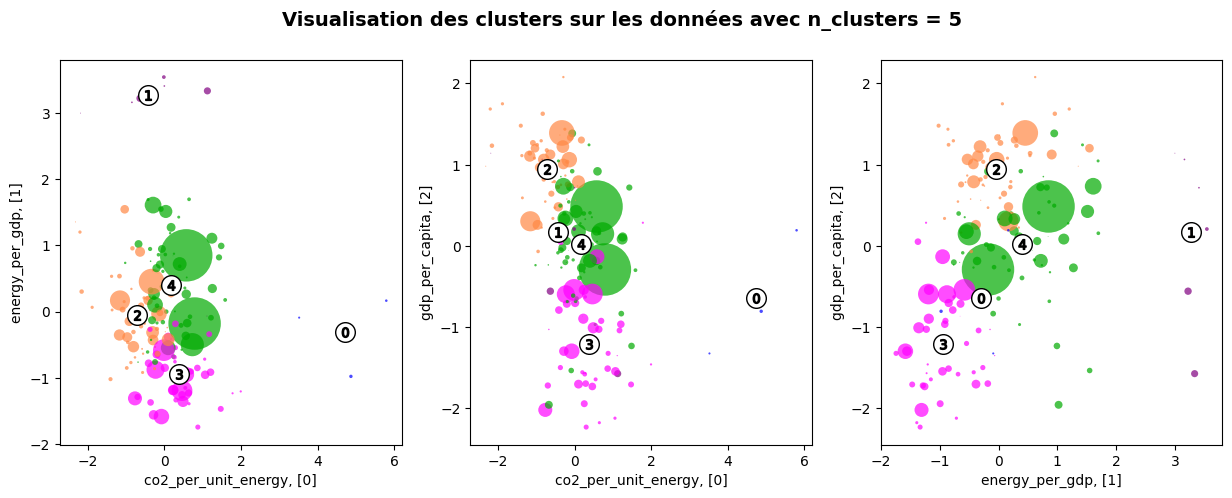

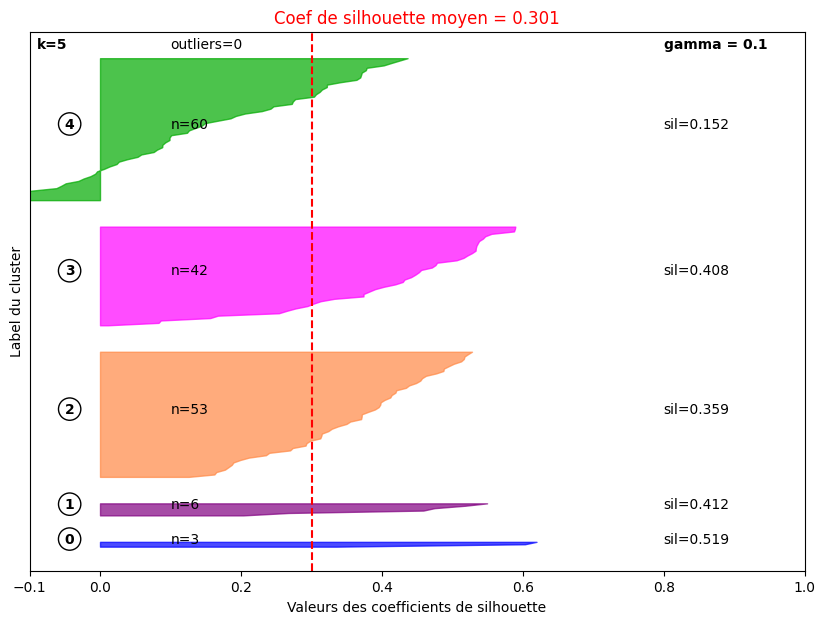

In [9]:
features_1 = ['co2', 'energy', 'gdp', 'population']
features_2 = ['co2_per_unit_energy', 'energy_per_gdp', 'gdp_per_capita'] 
features_3 = ['co2_per_unit_energy', 'energy_per_gdp', 'gdp_per_capita', 'population']
features = features_2

X =  preprocessing(df, years, countries, cols, features)
n_clusters = 5
gamma = 0.1
print("-"*20)
sc = SpectralClustering(
    n_clusters=n_clusters, affinity='rbf', assign_labels=assign_labels, random_state=rs
    )
cluster_labels = sc.fit_predict(X)

silhouette_avg = silhouette_score(X, cluster_labels)
silhouette_sample_values = silhouette_samples(X, cluster_labels)
df["cluster"] = cluster_labels
print(f"γ = {gamma}")
print(f"cluster: {n_clusters} --> tailles : {np.bincount(cluster_labels)} | silh_avg = {silhouette_avg:.3f}")



cluster_stats = df.groupby("cluster").agg(
    n_countries=("country", "count"),
    co2=("co2", "sum"),
    energy=("energy", "sum"),
    gdp=("gdp", "sum"),
    population=("population", "sum"),
    avg_co2_energy=("co2_per_unit_energy", "mean"),
    avg_energy_gdp=("energy_per_gdp", "mean"),
    avg_gdp_capita=("gdp_per_capita", "mean"),           
)
cluster_stats["silh_mean"] = [ np.mean(silhouette_sample_values[cluster_labels == i]) for i in range(n_clusters)]
        
for feat in ["co2", "energy", "gdp", "population"]:
    cluster_stats[f"%{feat}"] =  (cluster_stats[feat] / cluster_stats[feat].sum() * 100).round(2)
        
country_list = [ ", ".join(list(df[df["cluster"]==k]["country"])) for k in range(n_clusters) ]
# cluster_stats["country_list"] = country_list
for k, cl in enumerate(country_list):
    print(k, " > ", cl)
        



   
# print(cluster_stats)
display(HTML(cluster_stats.to_html().replace(
'<table>', '<table style="border-collapse:collapse; text-align:left;">')))

# GRAPHES :

centers = np.array([X[cluster_labels == i].mean(axis=0) for i in range(n_clusters)])
fig2 = display_clusters(X, n_clusters, features, centers, cluster_labels, df["population"])
fig1 = display_silhouettes(X, n_clusters, cluster_labels, gamma=gamma)


In [ ]:
display_3D(X,cluster_labels, df["population"], df["iso_code"])

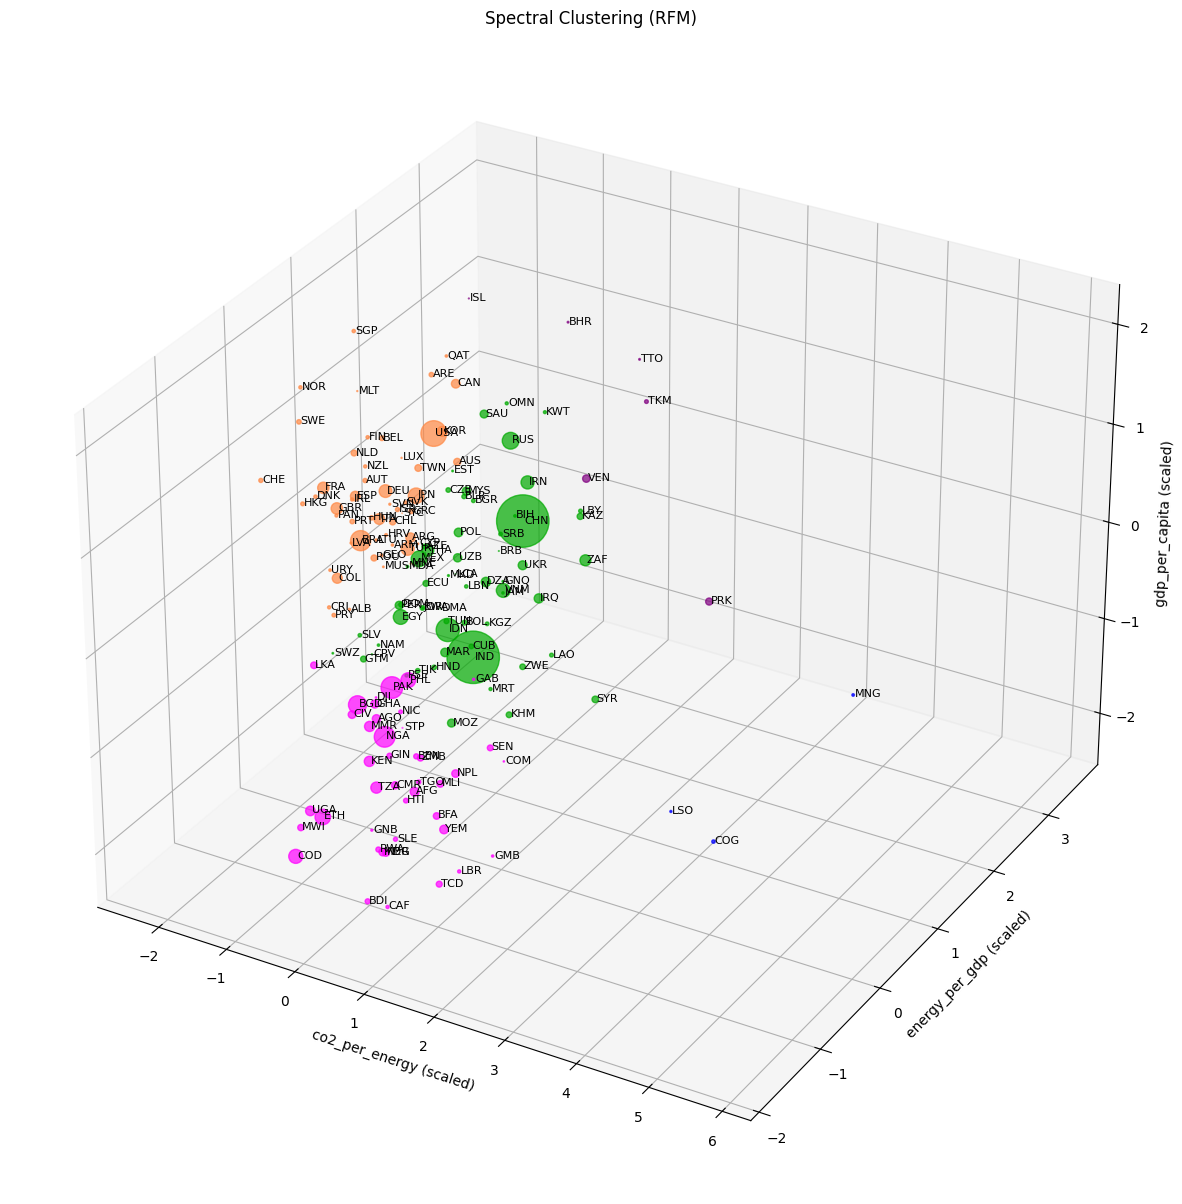

In [8]:
from mpl_toolkits.mplot3d import Axes3D

couleurs_vives = [
    "#0000FF",  # bleu
    "#800080",  # violet
    "#FF8844",  # orange
    "#FF00FF",  # magenta
    "#00AA00",  # vert
    "#00AAAA",  # cyan
    "#000000",  # noir
    "#FF0000",  # rouge
]

fig = plt.figure(figsize=(15, 20))
ax = fig.add_subplot(111, projection='3d')
cluster_colors = [couleurs_vives[i] for i in cluster_labels]
ax.scatter(
    X[:, 0], X[:, 1], X[:, 2],
    c=cluster_colors, s=df["population"]/1e6, alpha=0.7
)

for xi, yi, zi, label in zip(X[:, 0], X[:, 1], X[:, 2], df["iso_code"]):
    ax.text(xi+0.01, yi+0.01, zi+0.01, label, fontsize=8, ha='left', va='center')
    
ax.set_xlabel("co2_per_energy (scaled)")
ax.set_ylabel("energy_per_gdp (scaled)")
ax.set_zlabel("gdp_per_capita (scaled)")
ax.set_title("Spectral Clustering (RFM)")
plt.show()



In [14]:
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap
couleurs_vives = [
    "#0000FF",  # bleu
    "#800080",  # violet
    "#FF8844",  # orange
    "#FF00FF",  # magenta
    "#00AA00",  # vert
    "#00AAAA",  # cyan
    "#000000",  # noir
    "#FF0000",  # rouge
]

# Créer une colormap discrète

[couleurs_vives[i] for i in cluster_labels]



['#FF00FF',
 '#FF8844',
 '#00AA00',
 '#FF00FF',
 '#FF8844',
 '#FF8844',
 '#FF8844',
 '#FF8844',
 '#00AA00',
 '#800080',
 '#FF00FF',
 '#00AA00',
 '#00AA00',
 '#FF8844',
 '#FF00FF',
 '#00AA00',
 '#00AA00',
 '#00AA00',
 '#FF8844',
 '#00AA00',
 '#FF00FF',
 '#FF00FF',
 '#00AA00',
 '#FF00FF',
 '#FF8844',
 '#00AA00',
 '#FF00FF',
 '#FF00FF',
 '#FF8844',
 '#00AA00',
 '#FF8844',
 '#FF00FF',
 '#0000FF',
 '#FF8844',
 '#FF00FF',
 '#FF8844',
 '#00AA00',
 '#FF8844',
 '#00AA00',
 '#FF00FF',
 '#FF8844',
 '#FF00FF',
 '#00AA00',
 '#00AA00',
 '#00AA00',
 '#00AA00',
 '#00AA00',
 '#00AA00',
 '#00AA00',
 '#00AA00',
 '#FF00FF',
 '#FF8844',
 '#FF8844',
 '#FF00FF',
 '#FF00FF',
 '#FF8844',
 '#FF8844',
 '#FF00FF',
 '#FF8844',
 '#00AA00',
 '#FF00FF',
 '#FF00FF',
 '#FF00FF',
 '#00AA00',
 '#FF8844',
 '#FF8844',
 '#800080',
 '#00AA00',
 '#00AA00',
 '#00AA00',
 '#00AA00',
 '#FF8844',
 '#FF8844',
 '#FF8844',
 '#00AA00',
 '#FF8844',
 '#00AA00',
 '#00AA00',
 '#FF00FF',
 '#00AA00',
 '#00AA00',
 '#00AA00',
 '#FF8844',
 '#0

In [39]:
l = ["abc", "def", "ghi"]
" | ".join(l)

'abc | def | ghi'